# Loading in all Requied Packages 

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pycoingecko as pycoin


# Pulling In data from CoinGecko API

In [2]:
cg = pycoin.CoinGeckoAPI()
raw_data = cg.get_coin_market_chart_by_id(id = 'bitcoin',vs_currency= 'usd',days = 650)
price_data = pd.json_normalize(raw_data,record_path = 'prices')
price_data['clean_date'] = pd.to_datetime(price_data[0], unit='ms')
df = price_data.copy()
print(price_data)

                 0             1          clean_date
0    1591142400000   9515.243859 2020-06-03 00:00:00
1    1591228800000   9645.227869 2020-06-04 00:00:00
2    1591315200000   9776.202992 2020-06-05 00:00:00
3    1591401600000   9636.965527 2020-06-06 00:00:00
4    1591488000000   9662.858709 2020-06-07 00:00:00
..             ...           ...                 ...
646  1646956800000  39468.354773 2022-03-11 00:00:00
647  1647043200000  38775.175588 2022-03-12 00:00:00
648  1647129600000  38903.693548 2022-03-13 00:00:00
649  1647216000000  37852.525141 2022-03-14 00:00:00
650  1647226761000  38067.213114 2022-03-14 02:59:21

[651 rows x 3 columns]


# Normalizing Dataset

In [3]:
del price_data['clean_date']
del price_data[0]
scaler = MinMaxScaler(feature_range=(0,1))
close_df = scaler.fit_transform(np.array(price_data).reshape(-1,1))

# Splitting data set into a traing and test DF

In [4]:
training_size = int(len(close_df)*0.9)
test_size = len(close_df)-training_size
train_data = close_df[0:training_size,:]
test_data = close_df[training_size:len(close_df),:1]
print('train_data: ', train_data.shape)
print('test_data: ', test_data.shape)

train_data:  (585, 1)
test_data:  (66, 1)


# Makinghe Test and Train Data Matrix

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
time_step = 10 
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# reshape input to be [samples, time steps, features] which is required for LSTMX_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (574, 10)
X_test:  (55, 10, 1)


# Setting the Model Perameters

In [8]:
model = Sequential() 
# Adding a LSTM layer with 10 internal units
model.add(LSTM(10,input_shape=(None,1),activation='relu'))
# Adding a Dense layer with 1 units.
model.add(Dense(1))
# Loss function + optimizer
model.compile(loss='mean_squared_error',optimizer='adam')

# Fitting the Model

In [9]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=10,verbose=1)

Epoch 1/100
58/58 [==============================] - 2s 9ms/step - loss: 0.1081 - val_loss: 0.0226
Epoch 2/100
58/58 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0032
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 4/100
58/58 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 5/100
58/58 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 8/100
58/58 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 9/100
58/58 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 10/100
58/58 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 11/

# Ploting the Loss Function for Traing and Test Set

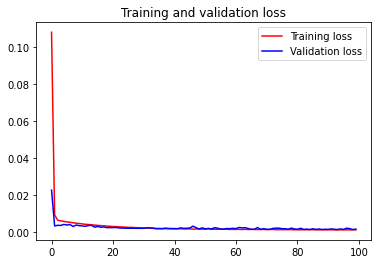

<Figure size 432x288 with 0 Axes>

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Making Vector of predicted Values

In [11]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict



# Plotting the Predicted and Actual Values

In [12]:
names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': df['clean_date'],
                    'original_close': df[1],
                    'train_predicted_close' : 0 ,
                    'test_predicted_close' : 0})

plotdf['train_predicted_close'] = np.nan_to_num(scaler.inverse_transform(trainPredictPlot))
plotdf['test_predicted_close'] = np.nan_to_num(scaler.inverse_transform(testPredictPlot))

plotdf['train_predicted_close'] = plotdf['train_predicted_close'].replace(0, np.NaN)
plotdf['test_predicted_close'] = plotdf['test_predicted_close'].replace(0, np.NaN)

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],plotdf['test_predicted_close']],
                labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original vs predicted close price',
                plot_bgcolor='white',legend_title_text='Close Price')                               

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()